In [56]:
import jinja2
from pydantic import BaseModel
from pydantic.main import ModelMetaclass



from cyclops.report.model_card.model_card import (
    Citation,
    Dataset,
    FairnessAssessment,
    KeyVal,
    License,
    Limitation,
    ModelCard,
    Owner,
    PerformanceMetric,
    Reference,
    Risk,
    SensitiveData,
    Tradeoff,
    UseCase,
    User,
    GraphicsCollection,
    Graphic,
    FairnessReport,
    ExplainabilityReport
)

from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

In [2]:
nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

## Get confusion matrix and ROC curve on train/test set

In [49]:
from scour import scour
from io import BytesIO, StringIO
import matplotlib.pyplot as plt
import base64

def svg_encode(svg: str):
    # Ref: https://bl.ocks.org/jennyknuth/222825e315d45a738ed9d6e04c7a88d0
    # Encode an SVG string so it can be embedded into a data URL.
    enc_chars = '"%#{}<>'  # Encode these to %hex
    enc_chars_maybe = "&|[]^`;?:@="  # Add to enc_chars on exception
    svg_enc = ""
    # Translate character by character
    for c in str(svg):
        if c in enc_chars:
            if c == '"':
                svg_enc += "'"
            else:
                svg_enc += "%" + format(ord(c), "x")
        else:
            svg_enc += c
    return " ".join(svg_enc.split())  # Compact whitespace

def plot_to_str(format: str = "svg"):
    # Ref: https://github.com/cylynx/verifyml/blob/d3b4b3465493b802aba87edff81015f0db97805b/verifyml/model_tests/utils.py#L39
    # Utility function that will export a plot to a base-64 png encoded data URI scheme.
    if format == "svg":
        img = StringIO()
        plt.savefig(img, format="svg", bbox_inches="tight")
        scour_options = scour.sanitizeOptions()
        scour_options.remove_descriptive_elements = True
        return f"data:image/svg+xml,{svg_encode(scour.scourString(img.getvalue(), options = scour_options))}"
    else:
        img = BytesIO()
        plt.savefig(img, format=format, bbox_inches="tight")
        return f'data:image/{format};base64,{base64.encodebytes(img.getvalue()).decode("utf-8")}'
    
def plot_to_str_plotly(fig, format: str = "svg"):
    # Ref: https://github.com/cylynx/verifyml/blob/d3b4b3465493b802aba87edff81015f0db97805b/verifyml/model_tests/utils.py#L39
    # Utility function that will export a plot to a base-64 png encoded data URI scheme.
    if format == "svg":
        img = BytesIO()
        fig.write_image(img, format="svg")
        scour_options = scour.sanitizeOptions()
        scour_options.remove_descriptive_elements = True
        return f"data:image/svg+xml,{svg_encode(scour.scourString(img.getvalue(), options = scour_options))}"
    else:
        img = BytesIO()
        fig.write_image(img, format=format)
        return f'data:image/{format};base64,{base64.encodebytes(img.getvalue()).decode("utf-8")}'

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/51759 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

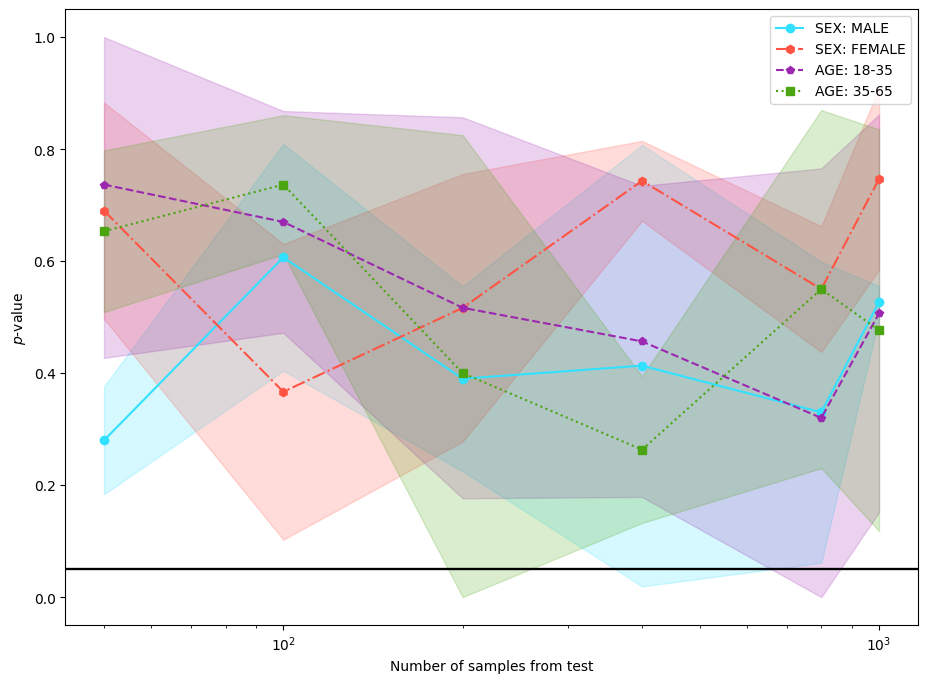

In [27]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

model = DenseNet(weights="densenet121-res224-nih")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=1000,
        target_sample_size=[50, 100, 200, 400, 800, 1000],
        num_runs=3,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)
drift_plot = plot_to_str()

In [10]:
from datasets.combine import concatenate_datasets  # noqa: E402
import torch

model.to(device)
model.eval()

def get_predictions_torch(examples):
    images = torch.stack(examples["features"]).squeeze(1)
    preds = model(images)
    return {"predictions": preds}


with nih_ds.formatted_as(
    "custom",
    columns=["features"],
    transform=partial(apply_transforms, transforms=transforms),
):
    preds_ds = nih_ds.map(
        get_predictions_torch,
        batched=True,
        batch_size=64,
        remove_columns=nih_ds.column_names,
    )

    nih_ds = concatenate_datasets([nih_ds, preds_ds], axis=1)

Map:   0%|          | 0/112120 [00:00<?, ? examples/s]

In [11]:
from cyclops.data.slicer import filter_value  # noqa: E402

# remove any rows with No Finding == 1
nih_ds = nih_ds.filter(
    partial(filter_value, column_name="No Finding", value=1, negate=True), batched=True
)

# remove the No Finding column and adjust the predictions to account for it
nih_ds = nih_ds.map(
    lambda x: {
        "predictions": x["predictions"][:14],
    },
    remove_columns=["No Finding"],
)
nih_ds.features

Filter:   0%|          | 0/112120 [00:00<?, ? examples/s]

Map:   0%|          | 0/51759 [00:00<?, ? examples/s]

{'Image Index': Value(dtype='string', id=None),
 'Finding Labels': Value(dtype='string', id=None),
 'Follow-up #': Value(dtype='int64', id=None),
 'Patient ID': Value(dtype='int64', id=None),
 'Patient Age': Value(dtype='int64', id=None),
 'Patient Gender': Value(dtype='string', id=None),
 'View Position': Value(dtype='string', id=None),
 'OriginalImage[Width': Value(dtype='int64', id=None),
 'Height]': Value(dtype='int64', id=None),
 'OriginalImagePixelSpacing[x': Value(dtype='float64', id=None),
 'y]': Value(dtype='float64', id=None),
 'Unnamed: 11': Value(dtype='float64', id=None),
 'features': Image(decode=True, id=None),
 'Atelectasis': Value(dtype='int64', id=None),
 'Cardiomegaly': Value(dtype='int64', id=None),
 'Consolidation': Value(dtype='int64', id=None),
 'Edema': Value(dtype='int64', id=None),
 'Effusion': Value(dtype='int64', id=None),
 'Emphysema': Value(dtype='int64', id=None),
 'Fibrosis': Value(dtype='int64', id=None),
 'Hernia': Value(dtype='int64', id=None),
 'Infi

In [89]:
from cyclops.evaluate import evaluator
from cyclops.evaluate.metrics.factory import create_metric
import numpy as np
import plotly.graph_objects as go

pathologies = model.pathologies[:14]

auroc = create_metric(
    metric_name="auroc",
    task="multilabel",
    num_labels=len(pathologies),
    thresholds=np.arange(0, 1, 0.01),
)

# define the slices
slices = [
    {"Patient Gender": {"value": "M"}},
    {"Patient Gender": {"value": "F"}},
]

# create the slice functions
slice_spec = SliceSpec(spec_list=slices)

nih_eval_results = evaluator.evaluate(
    dataset=nih_ds,
    metrics=auroc,
    feature_columns="features",
    target_columns=pathologies,
    prediction_column_prefix="predictions",
    remove_columns="features",
    slice_spec=slice_spec,
)

# plot the results
plots = []

for slice_name, slice_results in nih_eval_results.items():
    plots.append(
        go.Scatter(
            x=pathologies,
            y=slice_results["MultilabelAUROC"],
            name="Overall" if slice_name == "overall" else slice_name,
            mode="markers",
        )
    )

fig = go.Figure(data=plots)
fig.update_layout(
    # title="Multilabel AUROC by Pathology and Slice",
    title_x=0.5,
    title_font_size=20,
    xaxis_title="Pathology",
    yaxis_title="Multilabel AUROC",
    width=1024,
    height=768,
)
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
# perf_metric_gender = fig.to_image(format="svg")
perf_metric_gender = plot_to_str_plotly(fig, format="png")

Filter -> Patient Gender:M:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Gender:F:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> overall:   0%|          | 0/51759 [00:00<?, ? examples/s]

In [92]:
from cyclops.evaluate import evaluator
from cyclops.evaluate.metrics.factory import create_metric
import numpy as np
import plotly.graph_objects as go

pathologies = model.pathologies[:14]

auroc = create_metric(
    metric_name="auroc",
    task="multilabel",
    num_labels=len(pathologies),
    thresholds=np.arange(0, 1, 0.01),
)

# define the slices
slices = [
    {"Patient Age": {"min_value": 19, "max_value": 35}},
    {"Patient Age": {"min_value": 35, "max_value": 65}},
    {"Patient Age": {"min_value": 65, "max_value": 100}},
]

# create the slice functions
slice_spec = SliceSpec(spec_list=slices)

nih_eval_results = evaluator.evaluate(
    dataset=nih_ds,
    metrics=auroc,
    feature_columns="features",
    target_columns=pathologies,
    prediction_column_prefix="predictions",
    remove_columns="features",
    slice_spec=slice_spec,
)



# plot the results
plots = []

for slice_name, slice_results in nih_eval_results.items():
    plots.append(
        go.Scatter(
            x=pathologies,
            y=slice_results["MultilabelAUROC"],
            name="Overall" if slice_name == "overall" else slice_name,
            mode="markers",
        )
    )

fig = go.Figure(data=plots)
fig.update_layout(
    # title="Multilabel AUROC by Pathology and Slice",
    title_x=0.5,
    title_font_size=20,
    xaxis_title="Pathology",
    yaxis_title="Multilabel AUROC",
    width=1024,
    height=768,
)
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
# perf_metric_age = fig.to_image(format="svg")
perf_metric_age = plot_to_str_plotly(fig, format="png")

Filter -> Patient Age:[19 - 35]:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:[35 - 65]:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:[65 - 100]:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> overall:   0%|          | 0/51759 [00:00<?, ? examples/s]

In [18]:
from cyclops.evaluate.fairness import FairnessConfig  # noqa: E402
from cyclops.evaluate.fairness import evaluate_fairness  # noqa: E402

In [19]:
specificity = create_metric(
    metric_name="specificity",
    task="multilabel",
    num_labels=len(pathologies),
)
sensitivity = create_metric(
    metric_name="sensitivity",
    task="multilabel",
    num_labels=len(pathologies),
)

fpr = 1 - specificity
fnr = 1 - sensitivity

balanced_error_rate = (fpr + fnr) / 2

In [22]:
nih_fairness_result = evaluate_fairness(
    metrics=balanced_error_rate,
    metric_name="BalancedErrorRate",
    dataset=nih_ds,
    remove_columns="features",
    target_columns=pathologies,
    prediction_columns="predictions",
    groups=["Patient Age", "Patient Gender"],
    group_bins={"Patient Age": [20, 40, 60, 80]},
    group_base_values={"Patient Age": 20, "Patient Gender": "M"},
)

Filter -> Patient Age:(-inf - 20.0]&Patient Gender:M:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:(-inf - 20.0]&Patient Gender:F:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:(20.0 - 40.0]&Patient Gender:M:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:(20.0 - 40.0]&Patient Gender:F:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:(40.0 - 60.0]&Patient Gender:M:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:(40.0 - 60.0]&Patient Gender:F:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:(60.0 - 80.0]&Patient Gender:M:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:(60.0 - 80.0]&Patient Gender:F:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:(80.0 - inf]&Patient Gender:M:   0%|          | 0/51759 [00:00<?, ? examples/s]

Filter -> Patient Age:(80.0 - inf]&Patient Gender:F:   0%|          | 0/51759 [00:00<?, ? examples/s]

In [91]:
# plot metrics per slice
plots = []

for slice_name, slice_results in nih_fairness_result.items():
    plots.append(
        go.Scatter(
            x=pathologies,
            y=slice_results["BalancedErrorRate"],
            name=slice_name,
            mode="markers",
        )
    )

fig = go.Figure(data=plots)
fig.update_layout(
    # title="Balanced Error Rate by Pathology and Group",
    title_x=0.5,
    title_font_size=20,
    xaxis_title="Pathology",
    yaxis_title="Balanced Error Rate",
    width=1024,
    height=768,
)
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
# fairness_1 = fig.to_image(format="svg")
fairness_1 = plot_to_str_plotly(fig, format="png")

In [90]:


# plot parity difference per slice
plots = []

for slice_name, slice_results in nih_fairness_result.items():
    plots.append(
        go.Scatter(
            x=pathologies,
            y=slice_results["BalancedErrorRate Parity"],
            name=slice_name,
            mode="markers",
        )
    )

fig = go.Figure(data=plots)
fig.update_layout(
    # title="Balanced Error Rate Parity by Pathology and Group",
    title_x=0.5,
    title_font_size=20,
    xaxis_title="Pathology",
    yaxis_title="Balanced Error Rate Parity",
    width=1024,
    height=768,
)
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
# fairness_2 = fig.to_image(format="svg")
fairness_2 = plot_to_str_plotly(fig, format="png")

## Bootstrap model card from VerifyML model card editor and scaffold assets
We can add the quantitative analysis, explainability analysis and fairness analysis sections to a bootstrap model card for convenience. In this example, we use an existing model card which we created from the [VerifyML model card editor](https://report.verifyml.com/create). This is meant only as an example - the dataset and risk evaluation in the model card is a fictional use case.

In [79]:
# Initialize the model card
def scaffold_model(base_model: BaseModel) -> BaseModel:
    """Recursively initialize a pydantic model with default values."""
    assert isinstance(
        base_model, BaseModel
    ), f"Expected a pydantic BaseModel instance, got {type(base_model)} instead."

    for field in base_model.__fields__:
        field_type = base_model.__fields__[field].type_

        if (
            type(field_type) is ModelMetaclass
            and base_model.__fields__[field].default_factory is None
        ):
            sub_model = scaffold_model(field_type())
            setattr(base_model, field, sub_model)
        else:
            default = base_model.__fields__[field].default
            if base_model.__fields__[field].default_factory is not None:
                default = base_model.__fields__[field].default_factory()
            setattr(base_model, field, default)
    return base_model

## Populate model card fields

In [99]:
mc = ModelCard()
mc = scaffold_model(mc)

# model details for NIH Chest X-Ray model
mc.model_details.name = "NIH Chest X-Ray Multi-label Classification Model"

mc.model_details.overview = "This model is a DenseNet121 model trained on the NIH Chest X-Ray dataset."

mc.model_details.documentation = "The model was trained on the NIH Chest X-Ray dataset, \
    which contains 112,120 frontal-view X-ray images of 30,805 unique patients with the \
    fourteen text-mined disease labels from the associated radiological reports.  The labels \
    are Atelectasis, Cardiomegaly, Effusion, Infiltration, Mass, Nodule, Pneumonia, Pneumothorax, \
    Consolidation, Edema, Emphysema, Fibrosis, Pleural Thickening, and Hernia.  The model was \
    trained on 80% of the data and evaluated on the remaining 20%."
mc.model_details.references.append(
    Reference(reference="https://arxiv.org/abs/2111.00595")
)
mc.model_details.citations.append(
    Citation(
        style="APA",
        citation="""
        Joseph Paul Cohen, Joseph D. Viviano, Paul Bertin, Paul Morrison, Parsa Torabian, Matteo Guarrera, Matthew P Lungren, Akshay Chaudhari, Rupert Brooks, Mohammad Hashir, Hadrien Bertrand
        TorchXRayVision: A library of chest X-ray datasets and models. 
        Medical Imaging with Deep Learning
        https://github.com/mlmed/torchxrayvision, 2020
        """
    )
)
mc.model_parameters = None
# # model parameters
# mc.model_parameters.model_architecture = "DenseNet121 Convolutional Neural Network"
# mc.model_parameters.data.append(  # training set
#     Dataset(
#         name="NIH Chest X-Ray Dataset",
#         split="train",
#         size=len(nih_ds),
#         attributes=list(nih_ds.features),
#         sensitive=SensitiveData(
#             sensitive_data=["gender", "age"],
#             sensitive_data_used=["gender", "age"],
#             justification="Gender and age are sensitive patient attributes that are \
#                 associated with the risk of model bias regarding under-represented \
#                     populations."
#         ),
#     )
# )
# mc.model_parameters.data.append(  # test set
#     Dataset(
#         name="NIH Chest X-Ray Dataset",
#         split="test",
#         size=len(nih_ds),
#         attributes=list(nih_ds.features),
#     )
# )
# mc.model_parameters.input_format = "Hugging Face Dataset"

# considerations
mc.considerations.users.extend([User(description="Radiologists"),
                                 User(description="Data Scientists")]
)
mc.considerations.use_cases.append(
    UseCase(
        description="The model can be used to predict the presence of 14 pathologies \
            in chest X-ray images."
    )
)
mc.considerations.limitations.append(
            Limitation(
                # describe limits of chest x-ray classification model
                description="The limitations of this model include its inability to detect \
                    pathologies that are not included in the 14 labels of the NIH Chest X-Ray \
                    dataset. Additionally, the model may not perform well on images that are \
                    of poor quality or that contain artifacts. Finally, the model may not \
                    generalize well to populations that are not well-represented in the training \
                    data, such as patients from different geographic regions or with different \
                    demographics."
            )
)
mc.considerations.tradeoffs.append(
    Tradeoff(
        description="The model can help radiologists to detect pathologies in chest X-ray \
            images, but it may not generalize well to populations that are not well-represented \
            in the training data."
    )
)
mc.considerations.ethical_considerations.append(
    Risk(
        name="One ethical risk of the model is that it may not generalize well to populations that are not well-represented in the training data,\
              such as patients from different geographic regions or with different demographics. ",
        mitigation_strategy="A mitigation strategy for this risk is to ensure that the training data is diverse and representative of the population \
              that the model will be used on. Additionally, the model should be regularly evaluated and updated to ensure that it continues to perform \
                well on diverse populations. Finally, the model should be used in conjunction with human expertise to ensure that any biases or limitations \
                are identified and addressed."
    )
)
mc.considerations.fairness_assessment.append(
    FairnessAssessment(
        group_at_risk="Patients with rare pathologies",
        benefits="The model can help radiologists to detect pathologies in chest X-ray images.",
        harms="The model may not generalize well to populations that are not well-represented in the training data.",
        mitigation_strategy="A mitigation strategy for this risk is to ensure that the training data is diverse and representative of the population."
    )
)

# quantitative analysis

# Create 4 PerformanceMetric to store our results
mc.quantitative_analysis.performance_metrics = [
    PerformanceMetric() for i in range(0, 2)
]

mc.quantitative_analysis.performance_metrics[0].type = "MultiLabel AUROC by Pathology"
mc.quantitative_analysis.performance_metrics[0].slice = "Male/Female"
mc.quantitative_analysis.performance_metrics[0].graphics = GraphicsCollection()
mc.quantitative_analysis.performance_metrics[0].graphics.collection = [
    Graphic(name = "auroc_sex", image=perf_metric_gender)
]
mc.quantitative_analysis.performance_metrics[1].type = "MultiLabel AUROC by Pathology"
mc.quantitative_analysis.performance_metrics[1].slice = "Age Brackets"
mc.quantitative_analysis.performance_metrics[1].graphics = GraphicsCollection()
mc.quantitative_analysis.performance_metrics[1].graphics.collection = [
    Graphic(name = "auroc_age", image=perf_metric_age)
]

mc.fairness_analysis.fairness_reports = [
    FairnessReport() for i in range(0, 2)
]

mc.fairness_analysis.fairness_reports[0].type = "Balanced Error Rate by Pathology"
mc.fairness_analysis.fairness_reports[0].slice = None
mc.fairness_analysis.fairness_reports[0].segment = "Age and Gender"
mc.fairness_analysis.fairness_reports[0].description = None
mc.fairness_analysis.fairness_reports[0].graphics = GraphicsCollection()
mc.fairness_analysis.fairness_reports[0].graphics.collection = [
    Graphic(name = "fairness_ber", image=fairness_1)
]

mc.fairness_analysis.fairness_reports[1].type = "Balanced Error Rate Parity by Pathology"
mc.fairness_analysis.fairness_reports[1].slice = None
mc.fairness_analysis.fairness_reports[1].segment = "Age and Gender"
mc.fairness_analysis.fairness_reports[1].description = None
mc.fairness_analysis.fairness_reports[1].graphics = GraphicsCollection()
mc.fairness_analysis.fairness_reports[1].graphics.collection = [
    Graphic(name = "fairness_berp", image=fairness_2)
]

mc.explainability_analysis.explainability_reports = [
    ExplainabilityReport() for i in range(0, 1)
]

mc.explainability_analysis.explainability_reports[0].type = "Drift Sensitivity Experiment"
mc.explainability_analysis.explainability_reports[0].slice = "Age and Sex"
mc.explainability_analysis.explainability_reports[0].description = "Conduct sensitivity experiments to determine if the model is sensitive to changes in the input data \
    by slicing the data along patient attributes and increasing the prevalence of the attribute in the data."
mc.explainability_analysis.explainability_reports[0].graphics = GraphicsCollection()
mc.explainability_analysis.explainability_reports[0].graphics.collection = [
    Graphic(name = "drift_exp", image=drift_plot)
]

jinja_env = jinja2.Environment(
    loader=jinja2.FileSystemLoader("../model_card/template/"),
    autoescape=True,
    auto_reload=True,
    cache_size=0,
)
template = jinja_env.get_template("cyclops_template.jinja")
content = template.render(
    model_details=mc.model_details,
    model_parameters=mc.model_parameters,
    quantitative_analysis=mc.quantitative_analysis,
    explainability_analysis=mc.explainability_analysis,
    fairness_analysis=mc.fairness_analysis,
    considerations=mc.considerations,
)
with open("report.html", "w+") as f:
    f.write(content)
